In [37]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import os
try:
    import Image
except ImportError:
    from PIL import Image
import cv2
import numpy as np
# import pytesseract
from matplotlib import pyplot as plt
import math
from math import radians, degrees
from skewManager import imgproc
from skewManager.common import ROTATION, SKEW_X, SKEW_Y, DIRECTION_HORIZONTAL, DIRECTION_VERTICAL
from tabledetect import detectTable
import pandas as pd
import json
from BaiduAipOcr import BaiduAipOcr



tempout = "temp/"

In [38]:
def LineToArea(lines):
    area = []
    if len(lines) <= 1:
        return area
    for i in range(len(lines)-1):
        area.append((lines[i], lines[i+1]))
    return area


def imgtotable(img,rows,colums,debug=False):
    ocrclient = BaiduAipOcr()
    tablelist = [["" for col in range(0,len(colums))] for row in range(0,len(rows))]
    cloumarea = LineToArea(colums)
    rowsarea = LineToArea(rows)
    #print(tablelist)
    for row, (ystart,yend) in enumerate(rowsarea):
        
        print("行{}：".format(row),end=" ")
        for colum,(xstart,xend) in enumerate(cloumarea):
            roiimg = img[ystart:yend,
                  xstart:xend]


            if debug:
                
                cv2.imwrite("testimage/{}{}.jpg".format(row,colum),roiimg)

            try:
                print("列{}：".format(colum),end=" ")
                if debug:
                    text=" "
                    
                else:
                    text = ocrclient.image_to_stringforcv2(roiimg)
            except Exception as e:
                #print(e)
                print("RECT:[{}:{},{}:{}]".format(
                    ystart, xstart, yend, xend))
                text = "error"
            #print(row,colum)
            tablelist[row][colum] = text
        print(" ".format(row))
        #print("")
    return tablelist

In [18]:
from numba import jit

def removeStamp(dstimg,pointsTheshold=100,areathreshold = 10000.0,color = (255,255,255),debug=False):
    dstimgT = dstimg.copy()
    #if maskimg is None:
    imgThresh= cv2.bilateralFilter(dstimgT, 21, 21 * 2, 25 / 2);
    imgThresh = cv2.fastNlMeansDenoising(imgThresh, None, 21, 11, 21)
 
    imgrayT=cv2.Canny(imgThresh,100,240,3)#Canny边缘检测，参数可更改
    #ret,maskimgT = cv2.threshold(imgrayT,10,255,cv2.THRESH_BINARY)  
    maskimgT = cv2.adaptiveThreshold(
        imgrayT, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 35, 9)    
    image, contours, hierarchy = cv2.findContours(maskimgT,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)#contours为轮廓集，可以计算轮廓的长度、面积等  
    #emptyImageTT = np.zeros(maskimgT.shape, np.uint8)
    #print(len(contours))


    #plt.show() 
    for cnt in contours:  
        #print(len(cnt))
        if len(cnt) > pointsTheshold:  
            S1=cv2.contourArea(cnt)  
            ell=cv2.fitEllipse(cnt)  
            S2 =math.pi*ell[1][0]*ell[1][1] 
            #print(S2)
            if S1 > areathreshold and (S1/S2)>0.005 and S1 < 100000:#面积比例，可以更改，根据数据集。。。  
                #print(S1,S2,ell)
                #cv2.drawContours(emptyImageTT, cnt, -1, (255, 255, 255), 2)
                cv2.ellipse(dstimgT, ell,color, 15)
                cv2.ellipse(dstimgT, ell,color, cv2.FILLED)

    if debug:
        plt.gcf().set_size_inches(60.0,40.0)
        plt.subplot(2,1,1),plt.imshow(imgrayT,'gray')
        plt.subplot(2,1,2),plt.imshow(dstimgT,'gray')            
    return dstimgT

In [39]:
%reload_ext autoreload
%autoreload 2

canny_low_thresh=150
canny_high_thresh=250
canny_kernel_size=3
hough_rho_res=1
hough_theta_res=np.pi/650
hough_votes_thresh=750
hscale = 10
vscale = 10


def ocrimgtoexcel(filename,path,hscale = 10,vscale = 10,debug=False ):
    print('1：读取文件{}'.format(filename))
    filepath=os.path.join(path,filename)
    iproc_obj = imgproc.ImageProc(filepath)
    print('图像h={} w={}'.format(iproc_obj.input_img.shape[0],iproc_obj.input_img.shape[1]))

    print('2：去除hongse印章')
    print(debug)
    iproc_obj.removeRedStamp(debug=debug)
    if debug:
        plt.gcf().set_size_inches(60,30)
        plt.subplot(1,1,1),plt.imshow(iproc_obj.gray_img,'gray')
        plt.show()
    print('3：检测水平线和角度')
    sum = 0.0
    number = 0
    lines_hough = iproc_obj.detect_lines(canny_low_thresh=canny_low_thresh,
                                         canny_high_thresh=canny_high_thresh,
                                         canny_kernel_size=canny_kernel_size,
                                         hough_rho_res=1,
                                         hough_theta_res=hough_theta_res,
                                         hough_votes_thresh=hough_votes_thresh)


    img_lines = iproc_obj.draw_lines(orig_img_as_background=True)
    print('omit_on_rot_thresh: ',np.pi/10)
    theta_rotate = iproc_obj.find_rotation_or_skew2(rot_thresh=0.001, rot_same_dir_thresh=0.1, omit_on_rot_thresh=np.pi/10,only_direction=DIRECTION_HORIZONTAL)
    angle = degrees(theta_rotate[1])
    print("-----方向{} 校正角度 {}".format(theta_rotate[0],angle))
    if debug:
        plt.gcf().set_size_inches(90,50)
        plt.subplot(2,1,1),plt.imshow(iproc_obj.gray_img,'gray')
        plt.subplot(2,1,2),plt.imshow(img_lines,'gray')
        plt.show()
    print('3：水平校正')
    rotate_image = iproc_obj.rotate_image2(iproc_obj.gray_img,angle)
    print(rotate_image.shape)
    if debug:
        plt.gcf().set_size_inches(40,30)
        plt.subplot(1,1,1),plt.imshow(rotate_image,'gray')
        plt.show()
  
    print('4：检测表格上下横线')
    bordercut = 20
    x1= 0+bordercut
    y1= 0+bordercut    # 切掉周边，避免干扰
    x2= rotate_image.shape[1]-bordercut
    y2= rotate_image.shape[0]-bordercut
    dt = detectTable(rotate_image[y1:y2, x1:x2])
    #thresh_img = cv2.threshold(~rotate_image, 100, 255, cv2.THRESH_BINARY)[1]
    imgThresh= cv2.bilateralFilter(rotate_image, 21, 21 * 2, 25 / 2);
    imgThresh = cv2.fastNlMeansDenoising(imgThresh, None, 21, 11, 21)
    thresh_img = cv2.adaptiveThreshold(
        imgThresh, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 45, 9)
    h_img = thresh_img.copy()
    hscale = hscale
    h_size = int(h_img.shape[1]/hscale)

    h_structure = cv2.getStructuringElement(
        cv2.MORPH_RECT, (h_size, 1))  # 形态学因子
    h_dashed_structure = cv2.getStructuringElement(
        cv2.MORPH_RECT, (10, 1))  # 形态学因子
    h_dilate_imgT = cv2.dilate(h_img, h_dashed_structure, 1) # 虚线转为实线
    h_erode_img = cv2.erode(h_dilate_imgT, h_structure, 1) #腐蚀掉非水平的对象
    h_dilate_img = cv2.dilate(h_erode_img, h_structure, 1)


    v_img = thresh_img.copy()
    vscale = vscale
    v_size = int(v_img.shape[0]/vscale)

    v_structure = cv2.getStructuringElement(
        cv2.MORPH_RECT, (1, v_size))  # 形态学因子
    v_dashed_structure = cv2.getStructuringElement(
        cv2.MORPH_RECT, (1, 3))  # 形态学因子
    v_dilate_imgT = cv2.dilate(v_img, v_dashed_structure, 1) # 虚线转为实线
    v_erode_img = cv2.erode(v_dilate_imgT, v_structure, 1) #腐蚀掉非水平的对象
    v_dilate_img = cv2.dilate(v_erode_img, v_structure, 1)
    mask = h_dilate_img + v_dilate_img
    print(h_dilate_img.shape)
    print(v_dilate_img.shape)
    print(mask.shape)

    if debug:
        plt.gcf().set_size_inches(60,50)
        plt.subplot(2,1,1),plt.imshow(mask,'gray')
        plt.subplot(2,1,2),plt.imshow(thresh_img,'gray')
        plt.show()
        

    print('5：计算表格上下线坐标')
    border =1
    dtable = detectTable(rotate_image)
    h_threshold = int(rotate_image.shape[0]/8)
    v_threshold = int(rotate_image.shape[1]/10)

    x_count,x_segmentation = dtable.verticalShadowSplite(v_dilate_img,v_threshold)
    y_count,y_segmentation = dtable.horizontalShadowSplite(h_dilate_img,h_threshold)
    print(len(x_segmentation),len(y_segmentation))
    
    #print(len(y_segmentation))
    if debug:
        emptyImagev=dtable.getShadowimg(rotate_image,x_count,'V')
        emptyImageh=dtable.getShadowimg(rotate_image,y_count,'H')
        plt.gcf().set_size_inches(60.0,40.0)
        plt.subplot(2,1,1),plt.imshow(emptyImagev,'gray')
        plt.subplot(2,1,2),plt.imshow(emptyImageh,'gray')
        plt.show()

    prerows=dt.getLineCor(rotate_image.shape[0],y_segmentation) 
    if len(prerows) == 0:
        prerows.append(0)
        prerows.append(rotate_image.shape[0])
    if len(prerows) == 1:
        rows[0] = 0
        prerows.append(rotate_image.shape[0])

    precolums=dt.getLineCor(rotate_image.shape[1],x_segmentation)   
    print(precolums)
    if len(precolums) == 0:
        precolums.append(0)
        precolums.append(rotate_image.shape[1])

    if len(precolums) == 1:
        precolums[0] = 0
        precolums.append(rotate_image.shape[1])
    #colums=dt.getLineCor(rotate_image.shape[1],x_segmentation)  
    x1= precolums[0]+border
    y1= prerows[0]+border   # 切掉周边，避免干扰 for 
    x2= precolums[-1]-border
    y2= prerows[-1]-border
    print("左上角x1={} y1={},右下角x2={} y2={}".format(x1,y1,x2,y2))
    #rotate_image = removeStamp(rotate_image)  #去掉印章
    tablerect = rotate_image[y1:y2, x1:x2] #获取表格部分
    maskT = mask[y1:y2, x1:x2]
    if debug:
        print("行参考{}列参考{}".format(prerows,precolums))
        print(x_segmentation,y_segmentation)

        plt.gcf().set_size_inches(40.0,40.0)
        plt.subplot(2,1,1),plt.imshow(tablerect,'gray')
        plt.subplot(2,1,2),plt.imshow(maskT,'gray')
        plt.show()

    print('6：分割前预处理')
    # 消除噪音 ，便于分割
    print(maskT.shape,tablerect.shape)
    tableImgNoborder = cv2.add(maskT,tablerect) # 去掉边界

    imgbilateral= cv2.bilateralFilter(tableImgNoborder, 15, 50, 30);   # 双边滤波，去除噪音，边缘不变
    meansThresh = cv2.fastNlMeansDenoising(imgbilateral, None, 34, 21, 7) # 中值滤波，去除噪音
    thresh_img = cv2.adaptiveThreshold(
        meansThresh, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 25, 11) #二值化,通过阈值删除噪音
    x_structure = cv2.getStructuringElement(
        cv2.MORPH_RECT, (3, 3))
    if len(prerows) > 3:
        h_erode_img = maskT
    else:
        h_img = thresh_img.copy()
        hscale = hscale
        h_size = int(h_img.shape[1]/hscale)
        print(h_size)
        h_structure = cv2.getStructuringElement(
            cv2.MORPH_RECT, (h_size, 1))  # 形态学因子

        h_erode_structure = cv2.getStructuringElement(
            cv2.MORPH_RECT, (3, 3))
        #h_da_structure = cv2.getStructuringElement(
        #    cv2.MORPH_RECT, (10, 1)) # 形态学因子
        #h_dilate_imgT = cv2.dilate(h_img, h_da_structure, 1) # 横向膨胀
        #h_erode_img = cv2.erode(h_dilate_imgT, h_structure, 1) #腐蚀掉非水平的对象
        h_MORPH_CLOSE_img=    cv2.morphologyEx(h_img,cv2.MORPH_CLOSE,h_structure)
        h_erode_img = cv2.erode(h_MORPH_CLOSE_img, h_erode_structure, 1) 

    if len(precolums) > 3:
        v_erode_img = maskT
    else:
        v_img = thresh_img.copy()
        vscale = vscale
        v_size = int(v_img.shape[0]/vscale)

        v_structure = cv2.getStructuringElement(
            cv2.MORPH_RECT, (1, v_size))  # 形态学因子
        v_erode_structure = cv2.getStructuringElement(
            cv2.MORPH_RECT, (10, 3))  # 形态学因子
        #v_dilate_imgT = cv2.dilate(v_img, v_dashed_structure, 1) # 虚线转为实线
        #v_erode_img = cv2.erode(v_dilate_imgT, v_structure, 1) #腐蚀掉非水平的对象
        v_MORPH_CLOSE_img=    cv2.morphologyEx(v_img,cv2.MORPH_CLOSE,v_structure)
        v_erode_img = cv2.morphologyEx(v_MORPH_CLOSE_img, cv2.MORPH_CLOSE,v_erode_structure)
        #v_erode_img=    cv2.erode(v_MORPH_CLOSE_img,v_erode_structure)
    if debug:
        plt.gcf().set_size_inches(40.0,40.0)
        plt.subplot(3,1,1),plt.imshow(thresh_img,'gray')
        plt.subplot(3,1,2),plt.imshow(h_erode_img,'gray')
        plt.subplot(3,1,3),plt.imshow(v_erode_img,'gray')
        plt.show()



   
    print('7：计算行和列分割线')
    dt = detectTable(tableImgNoborder)
    h_threshold = int(tableImgNoborder.shape[1]/5)
    v_threshold = int(tableImgNoborder.shape[0]/5)

    x_count,x_segmentation = dt.verticalShadowSplite(v_erode_img,v_threshold)  #垂直投影
    y_count,y_segmentation = dt.horizontalShadowSplite(h_erode_img,h_threshold)  #水平投影

    rows=dt.getLineCor(tableImgNoborder.shape[0],y_segmentation, False if len(prerows) > 3 else True)   #至少5行
    colums=dt.getLineCor(tableImgNoborder.shape[1],x_segmentation, False if len(precolums) > 3 else True)     #至少4列
    if len(prerows) <= 3 and len(rows) > 2:
        rows[0]=0
        rows[-1]=tableImgNoborder.shape[1]
    if len(precolums) <= 3 and len(colums) > 2:
        colums[0]=0
        colums[-1]=tableImgNoborder.shape[1]
    if tableImgNoborder.shape[0] - rows[-1] >20:
        rows.append(tableImgNoborder.shape[0]-1)
    if tableImgNoborder.shape[1] - colums[-1] >20:    
        colums.append(tableImgNoborder.shape[1]-1)
    print(len(rows),len(colums))
    print('rows=',rows)
    print('colums=',colums)
    if debug:
        emptyImagev=dt.getShadowimg(tableImgNoborder,x_count,'V')
        emptyImageh=dt.getShadowimg(tableImgNoborder,y_count,'H')
        white = (255, 255, 255)
        black = (0, 0, 0)
        h,w=thresh_img.shape
        emptyImage = tableImgNoborder.copy()
        for x in colums:
            cv2.line(emptyImage, (x, 0), (x, h), black)
        for y in rows:

            cv2.line(emptyImage, (0, y), (w, y), black)
        cv2.imwrite('test.jpg',emptyImage)
        plt.gcf().set_size_inches(80.0,60.0)
        plt.subplot(3,1,1),plt.imshow(emptyImagev,'gray')
        plt.subplot(3,1,2),plt.imshow(emptyImageh,'gray')
        plt.subplot(3,1,3),plt.imshow(emptyImage,'gray')
        plt.show()
    
    print('8：每个cell进行识别的tablelist') 
    savename,extension = os.path.splitext(filename)
    tempoutpath=os.path.join(path,tempout)
    if not os.path.exists(tempoutpath):
        os.makedirs(tempoutpath)
    savepath = os.path.join(tempoutpath,savename+'.xlsx')      
    

    tablelist = imgtotable(tableImgNoborder,rows,colums,debug)
    print('9：保存文件')       


    df=pd.DataFrame(tablelist)

    if not os.path.exists(tempoutpath):
        os.makedirs(tempoutpath)
    savepath = os.path.join(tempoutpath,savename+'.xlsx')
    writer = pd.ExcelWriter(savepath)
    df.to_excel(writer, sheet_name=savename)
    writer.save()
    writer.close()
    print('10：{}.jpg '.format(savename))
    
    return tablelist
 

1：读取文件test.jpeg
图像h=684 w=1194
2：去除hongse印章
True


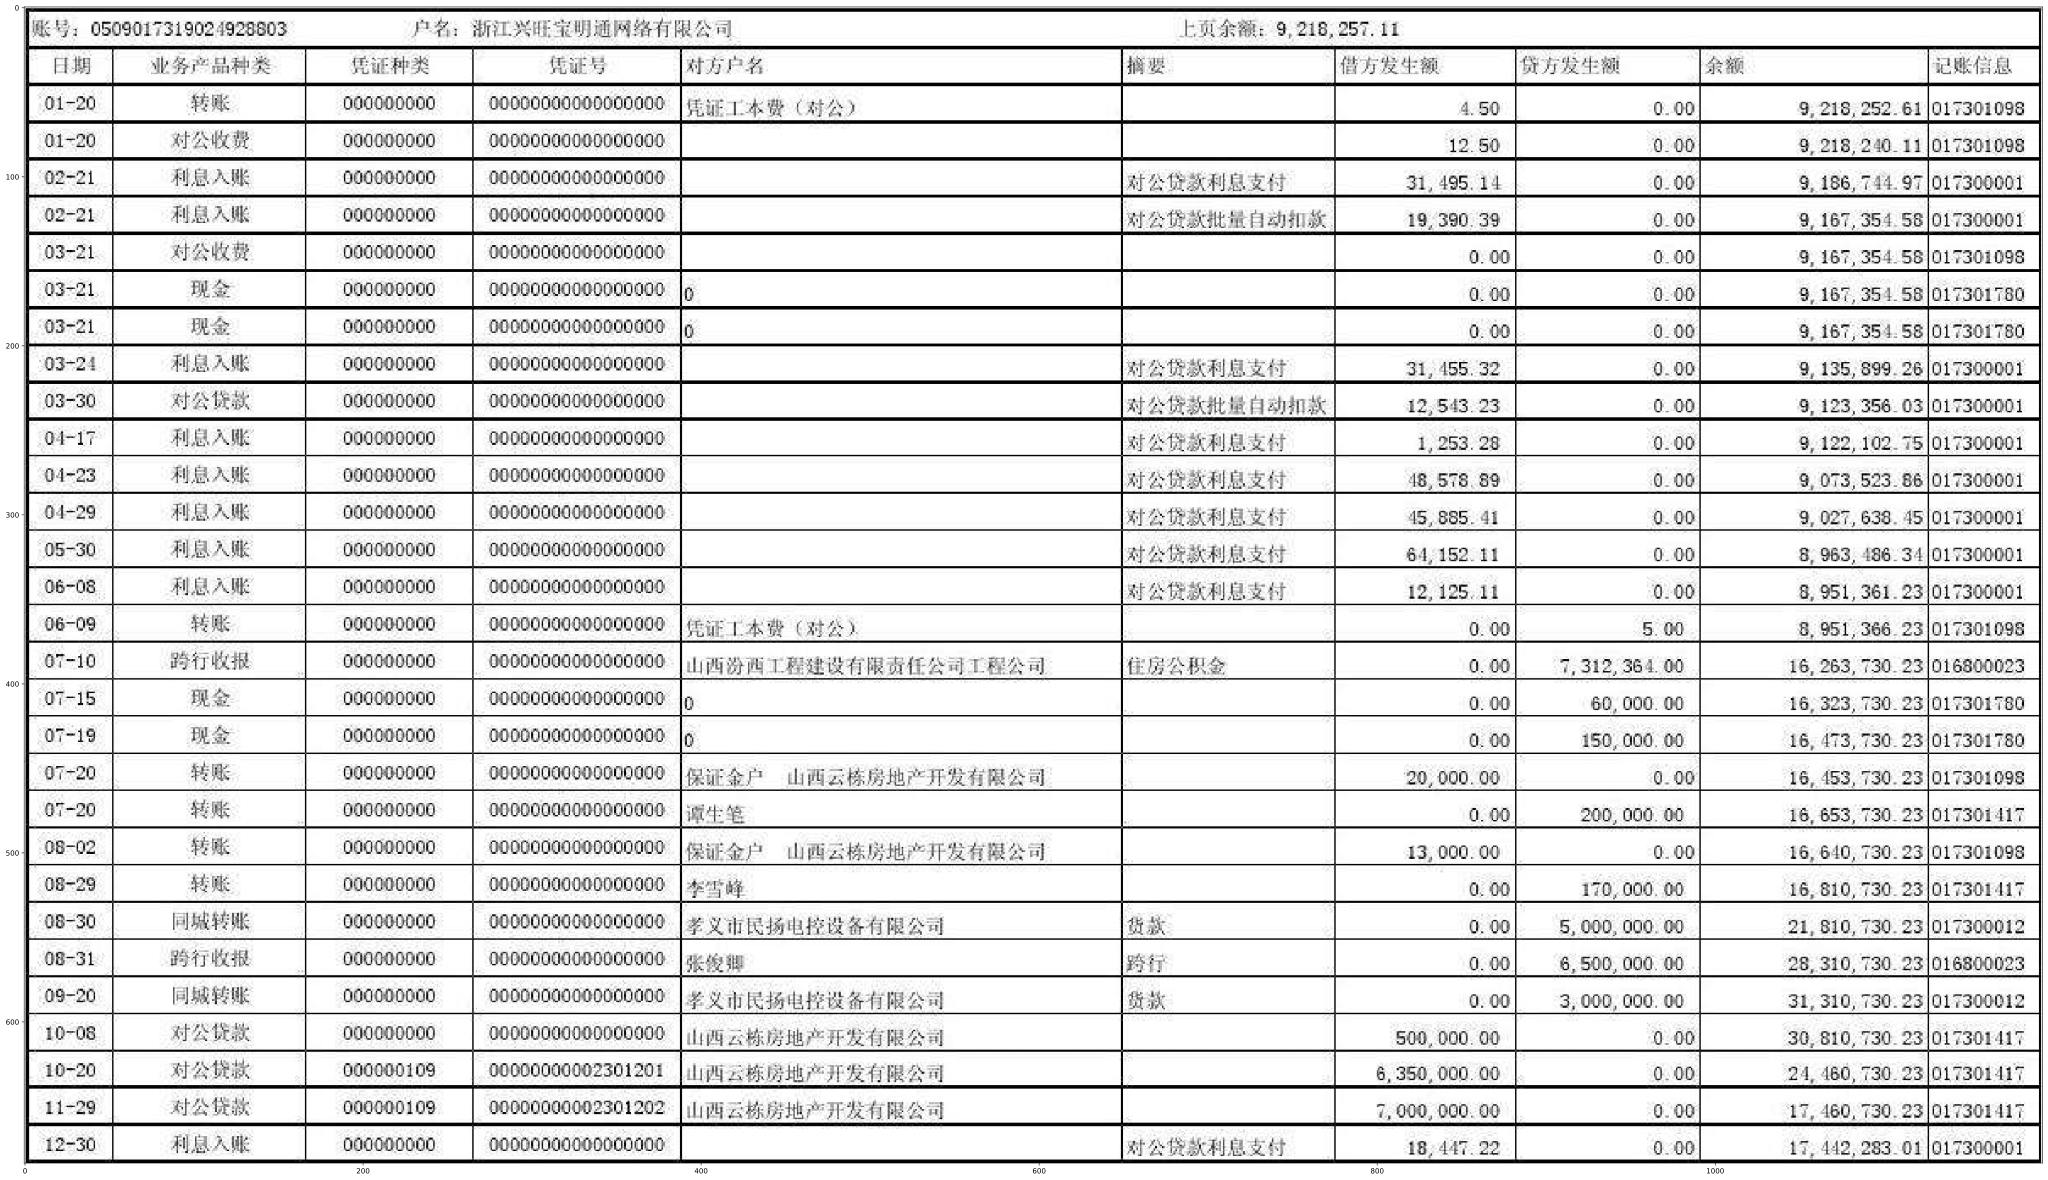

3：检测水平线和角度
omit_on_rot_thresh:  0.3141592653589793
4.371139006309477e-08 None False False
-----方向sx 校正角度 0.0


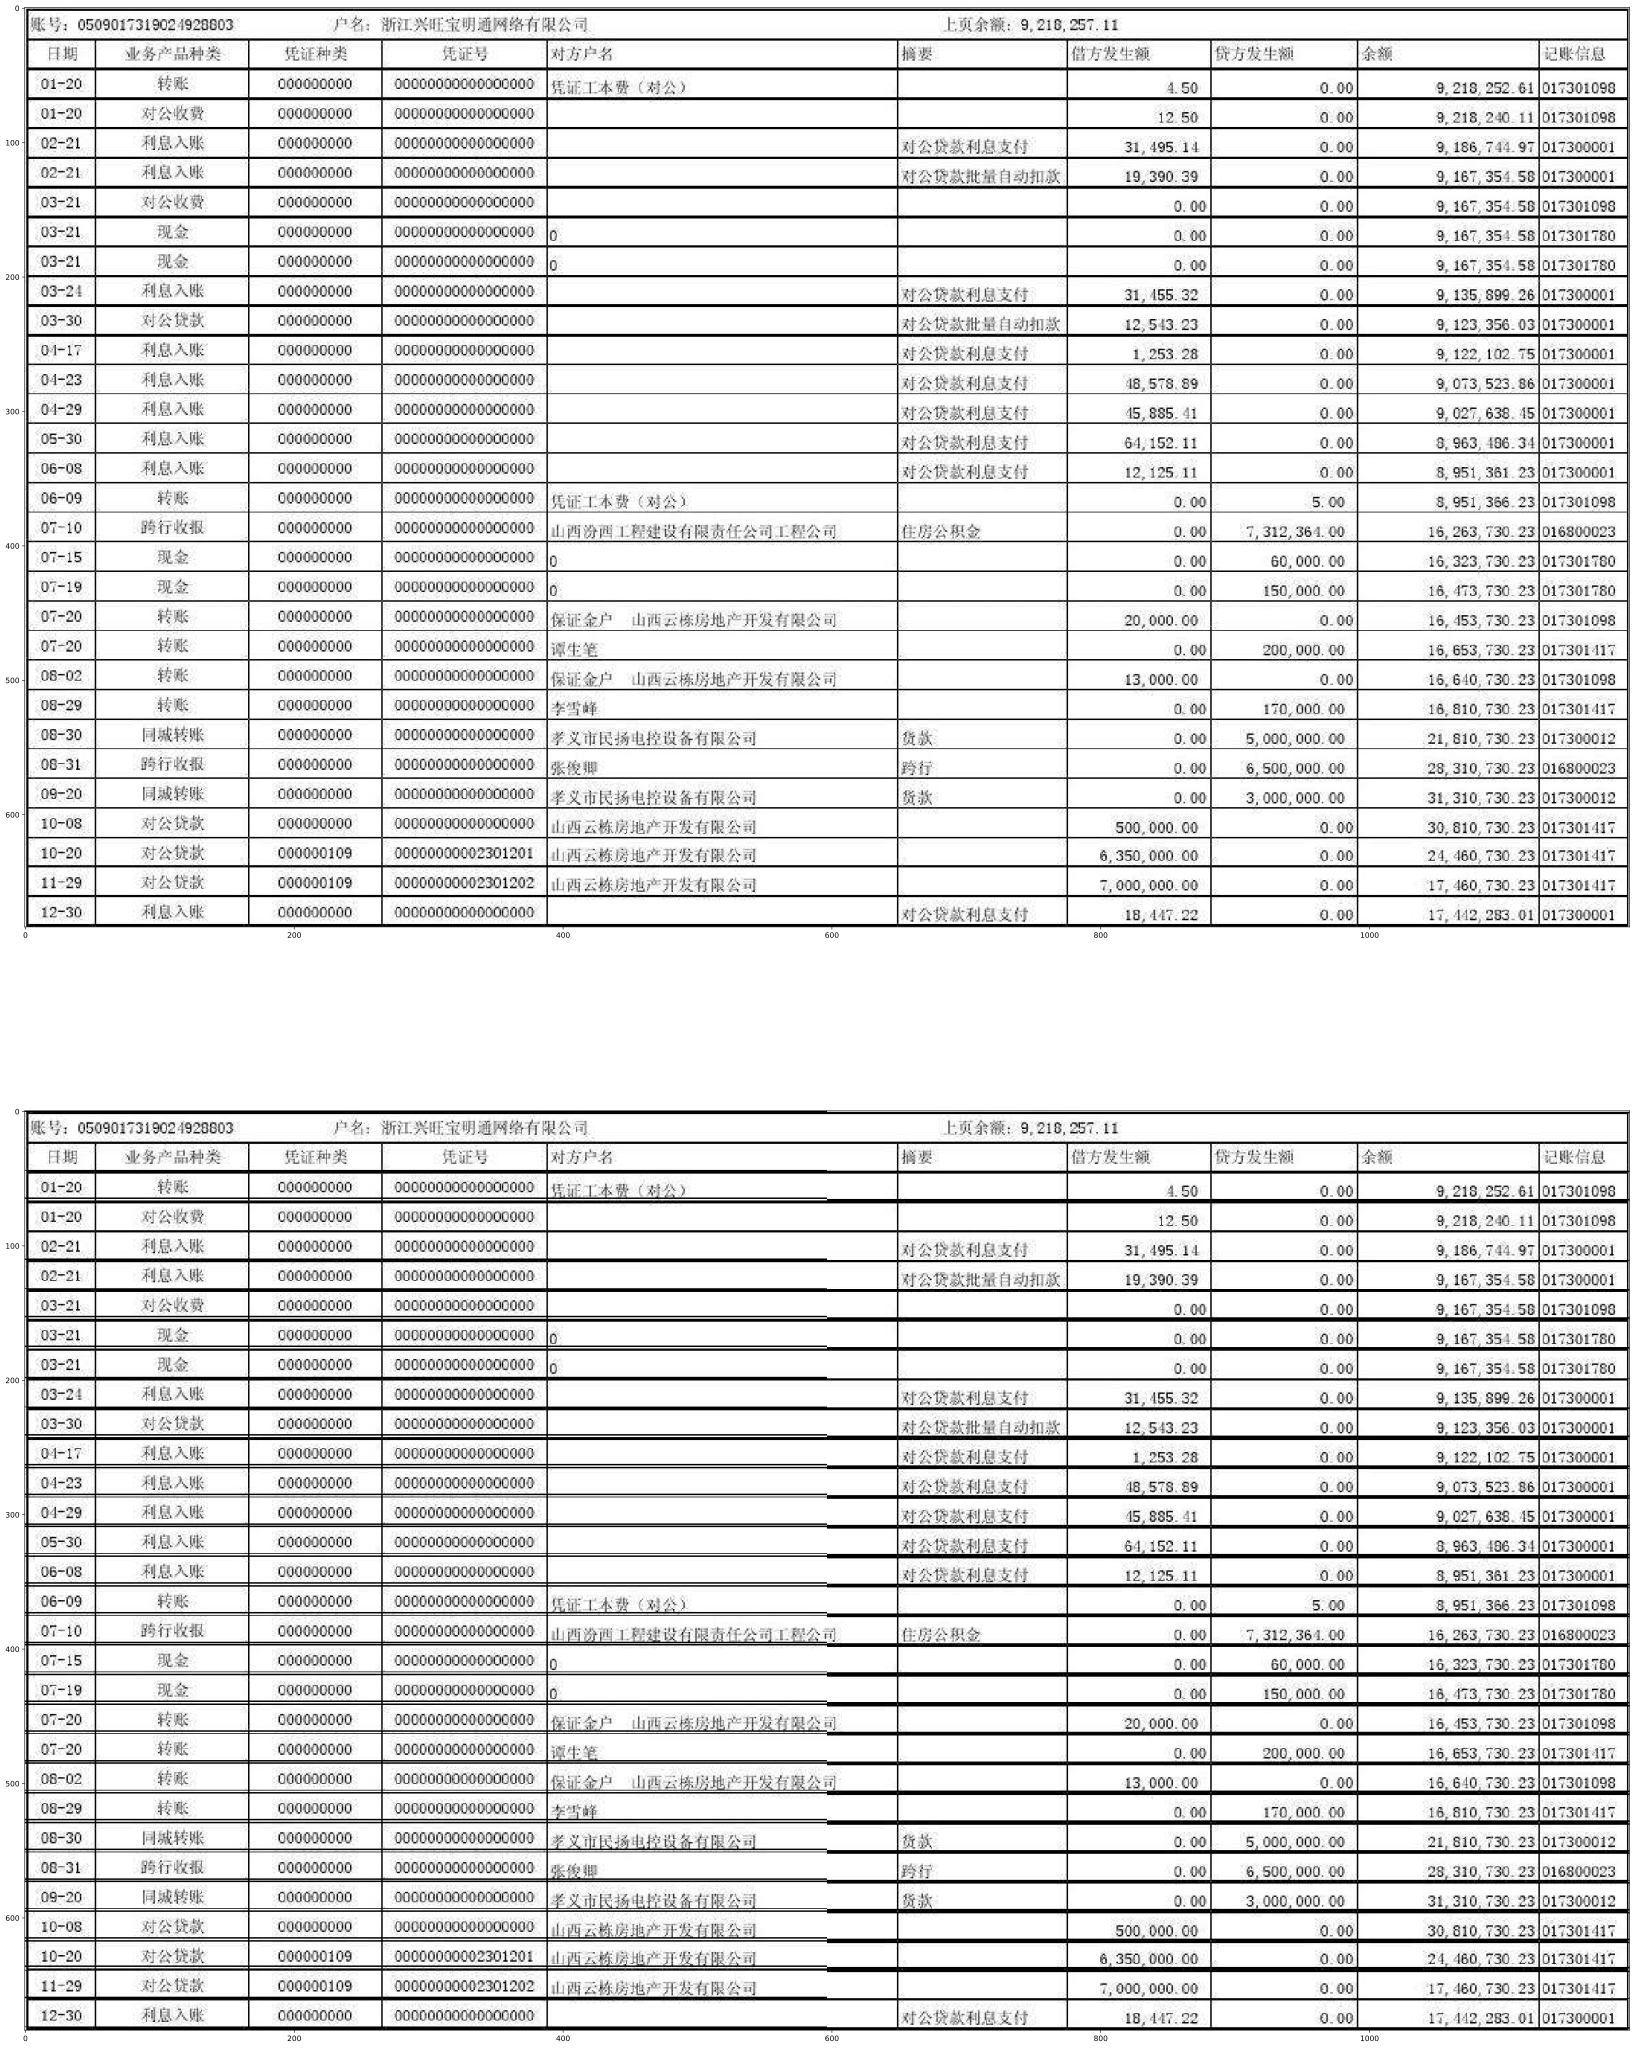

3：水平校正
校正角度0.0
(684, 1194)


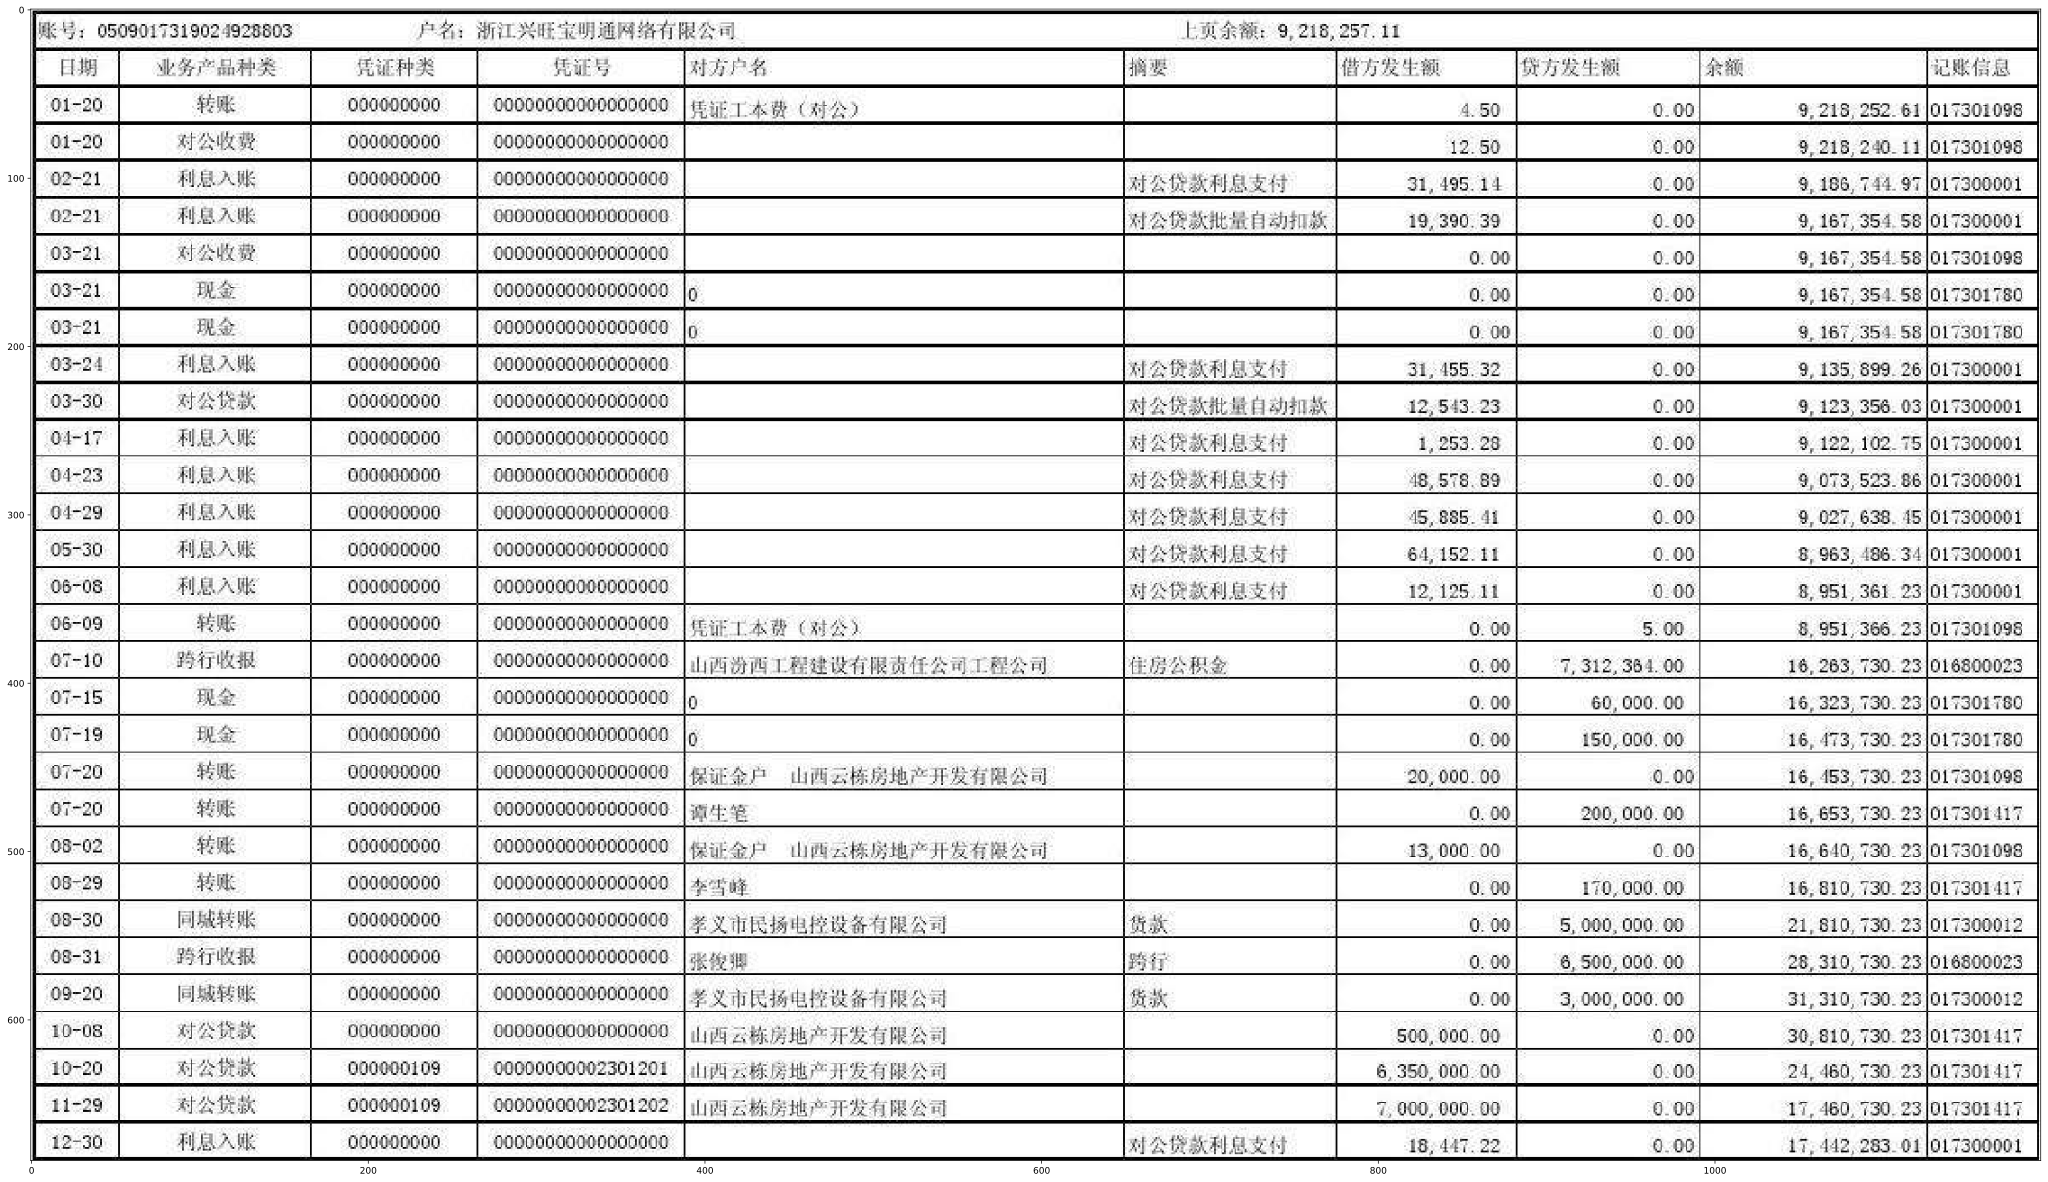

4：检测表格上下横线
(684, 1194)
(684, 1194)
(684, 1194)


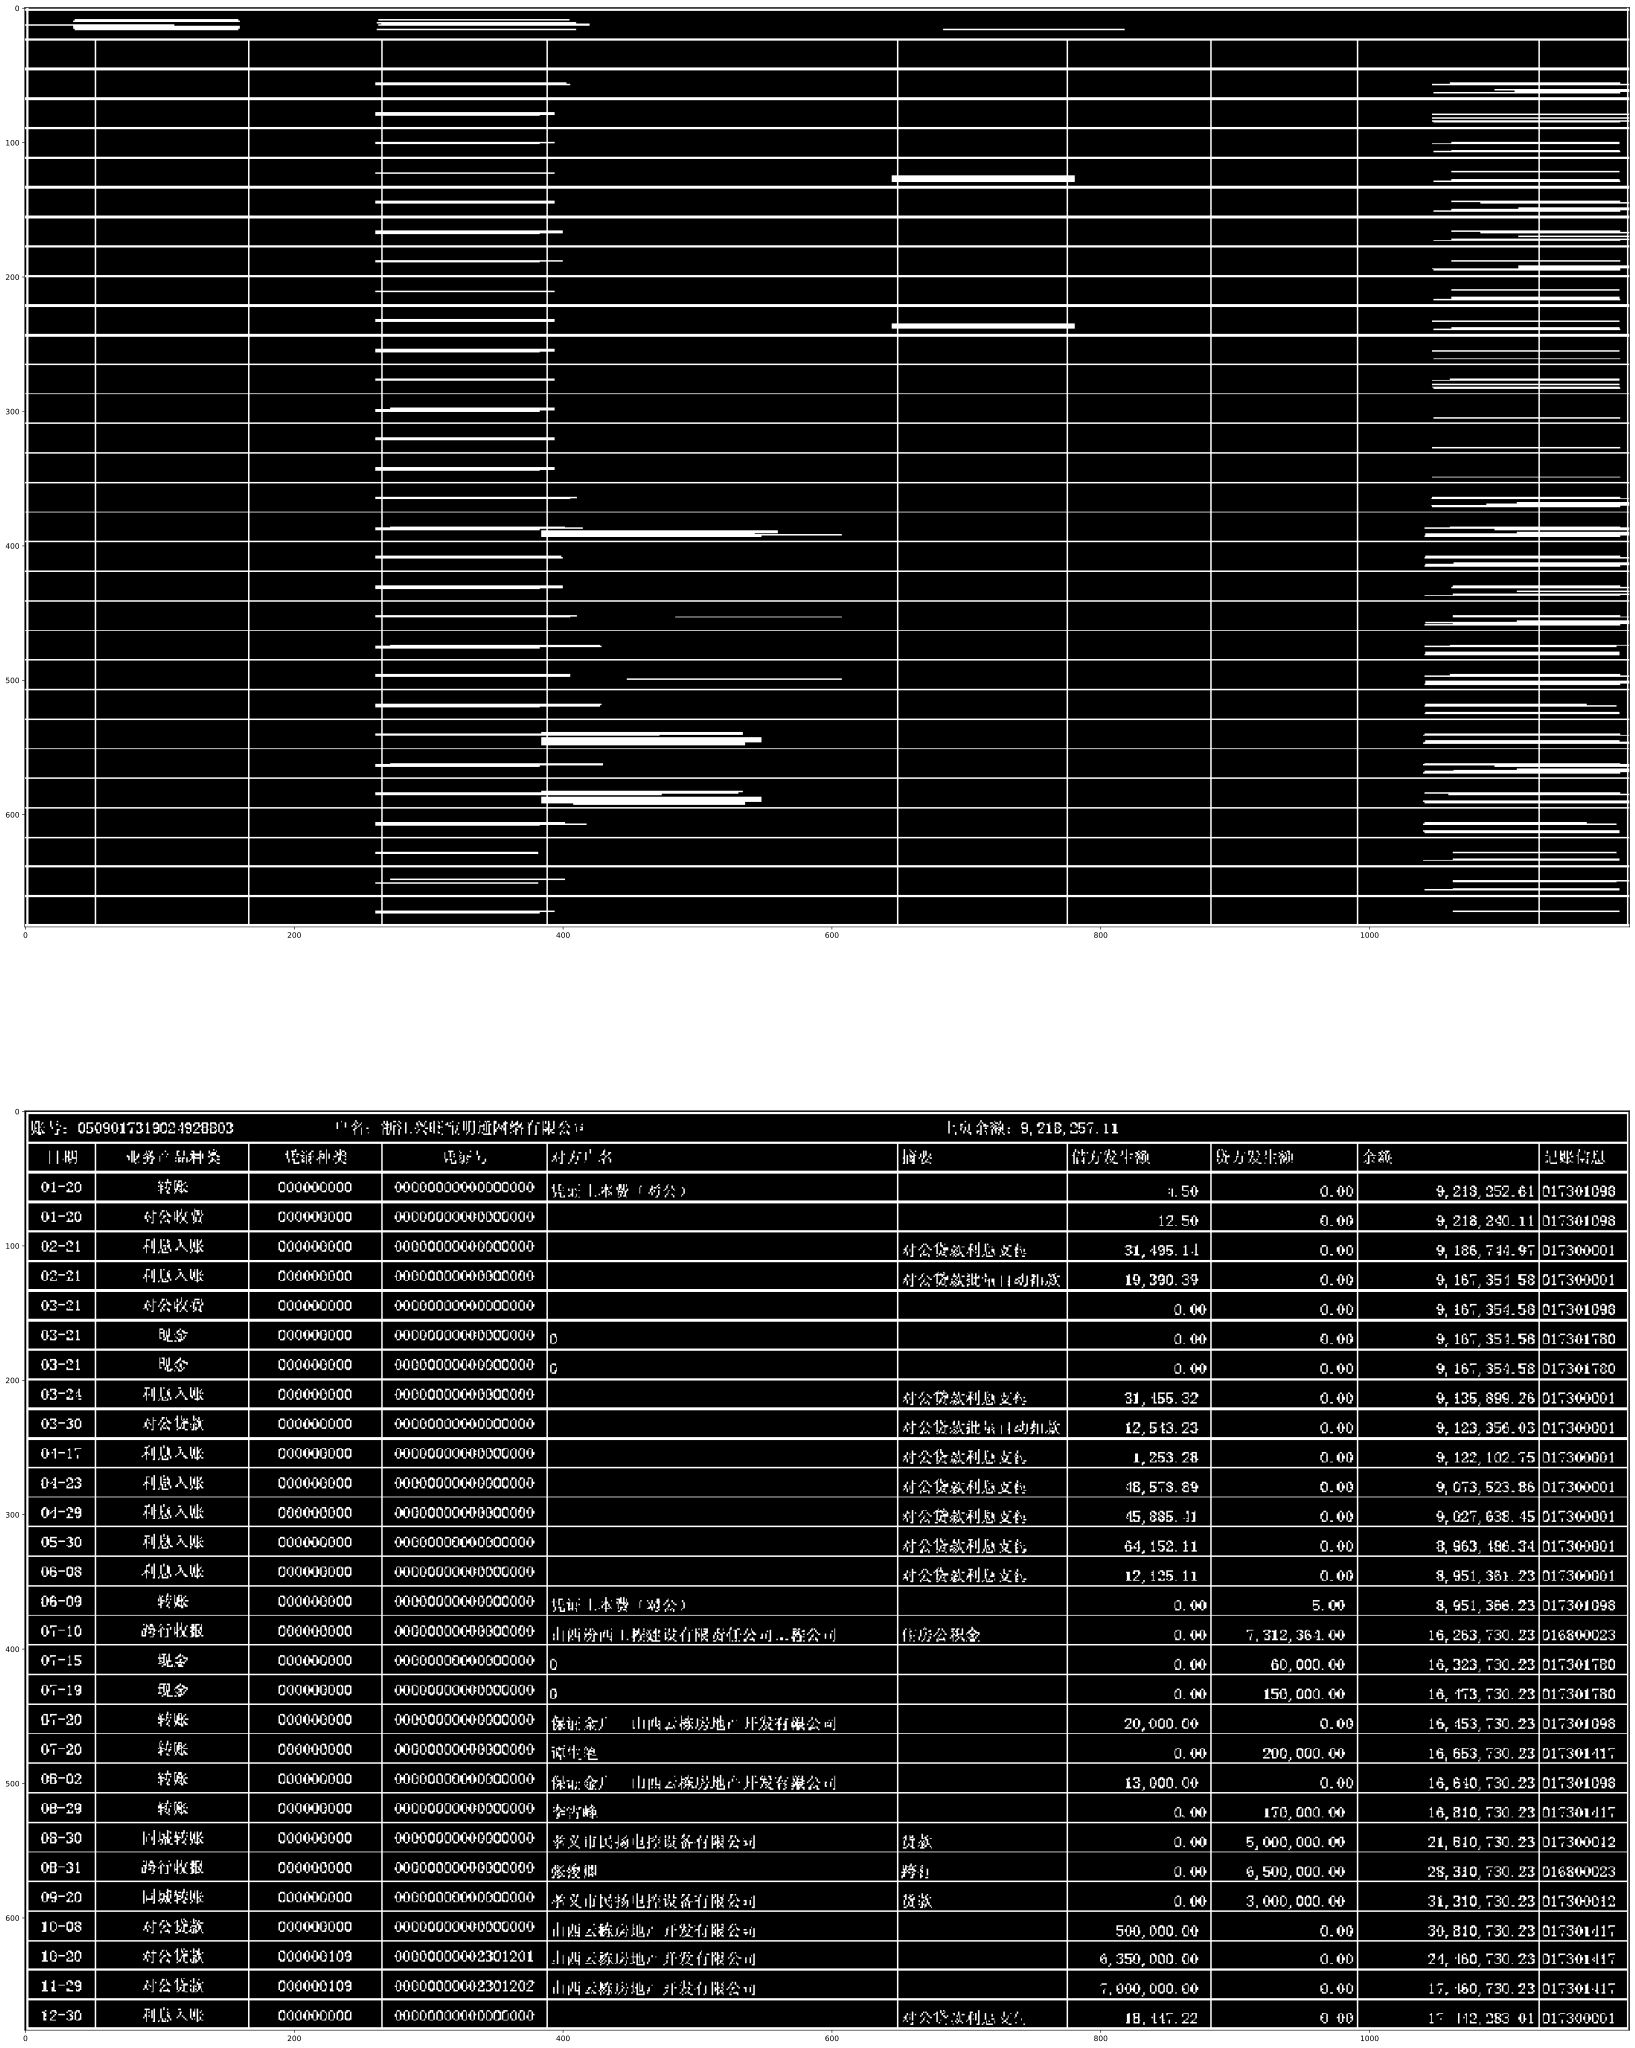

5：计算表格上下线坐标
11 91


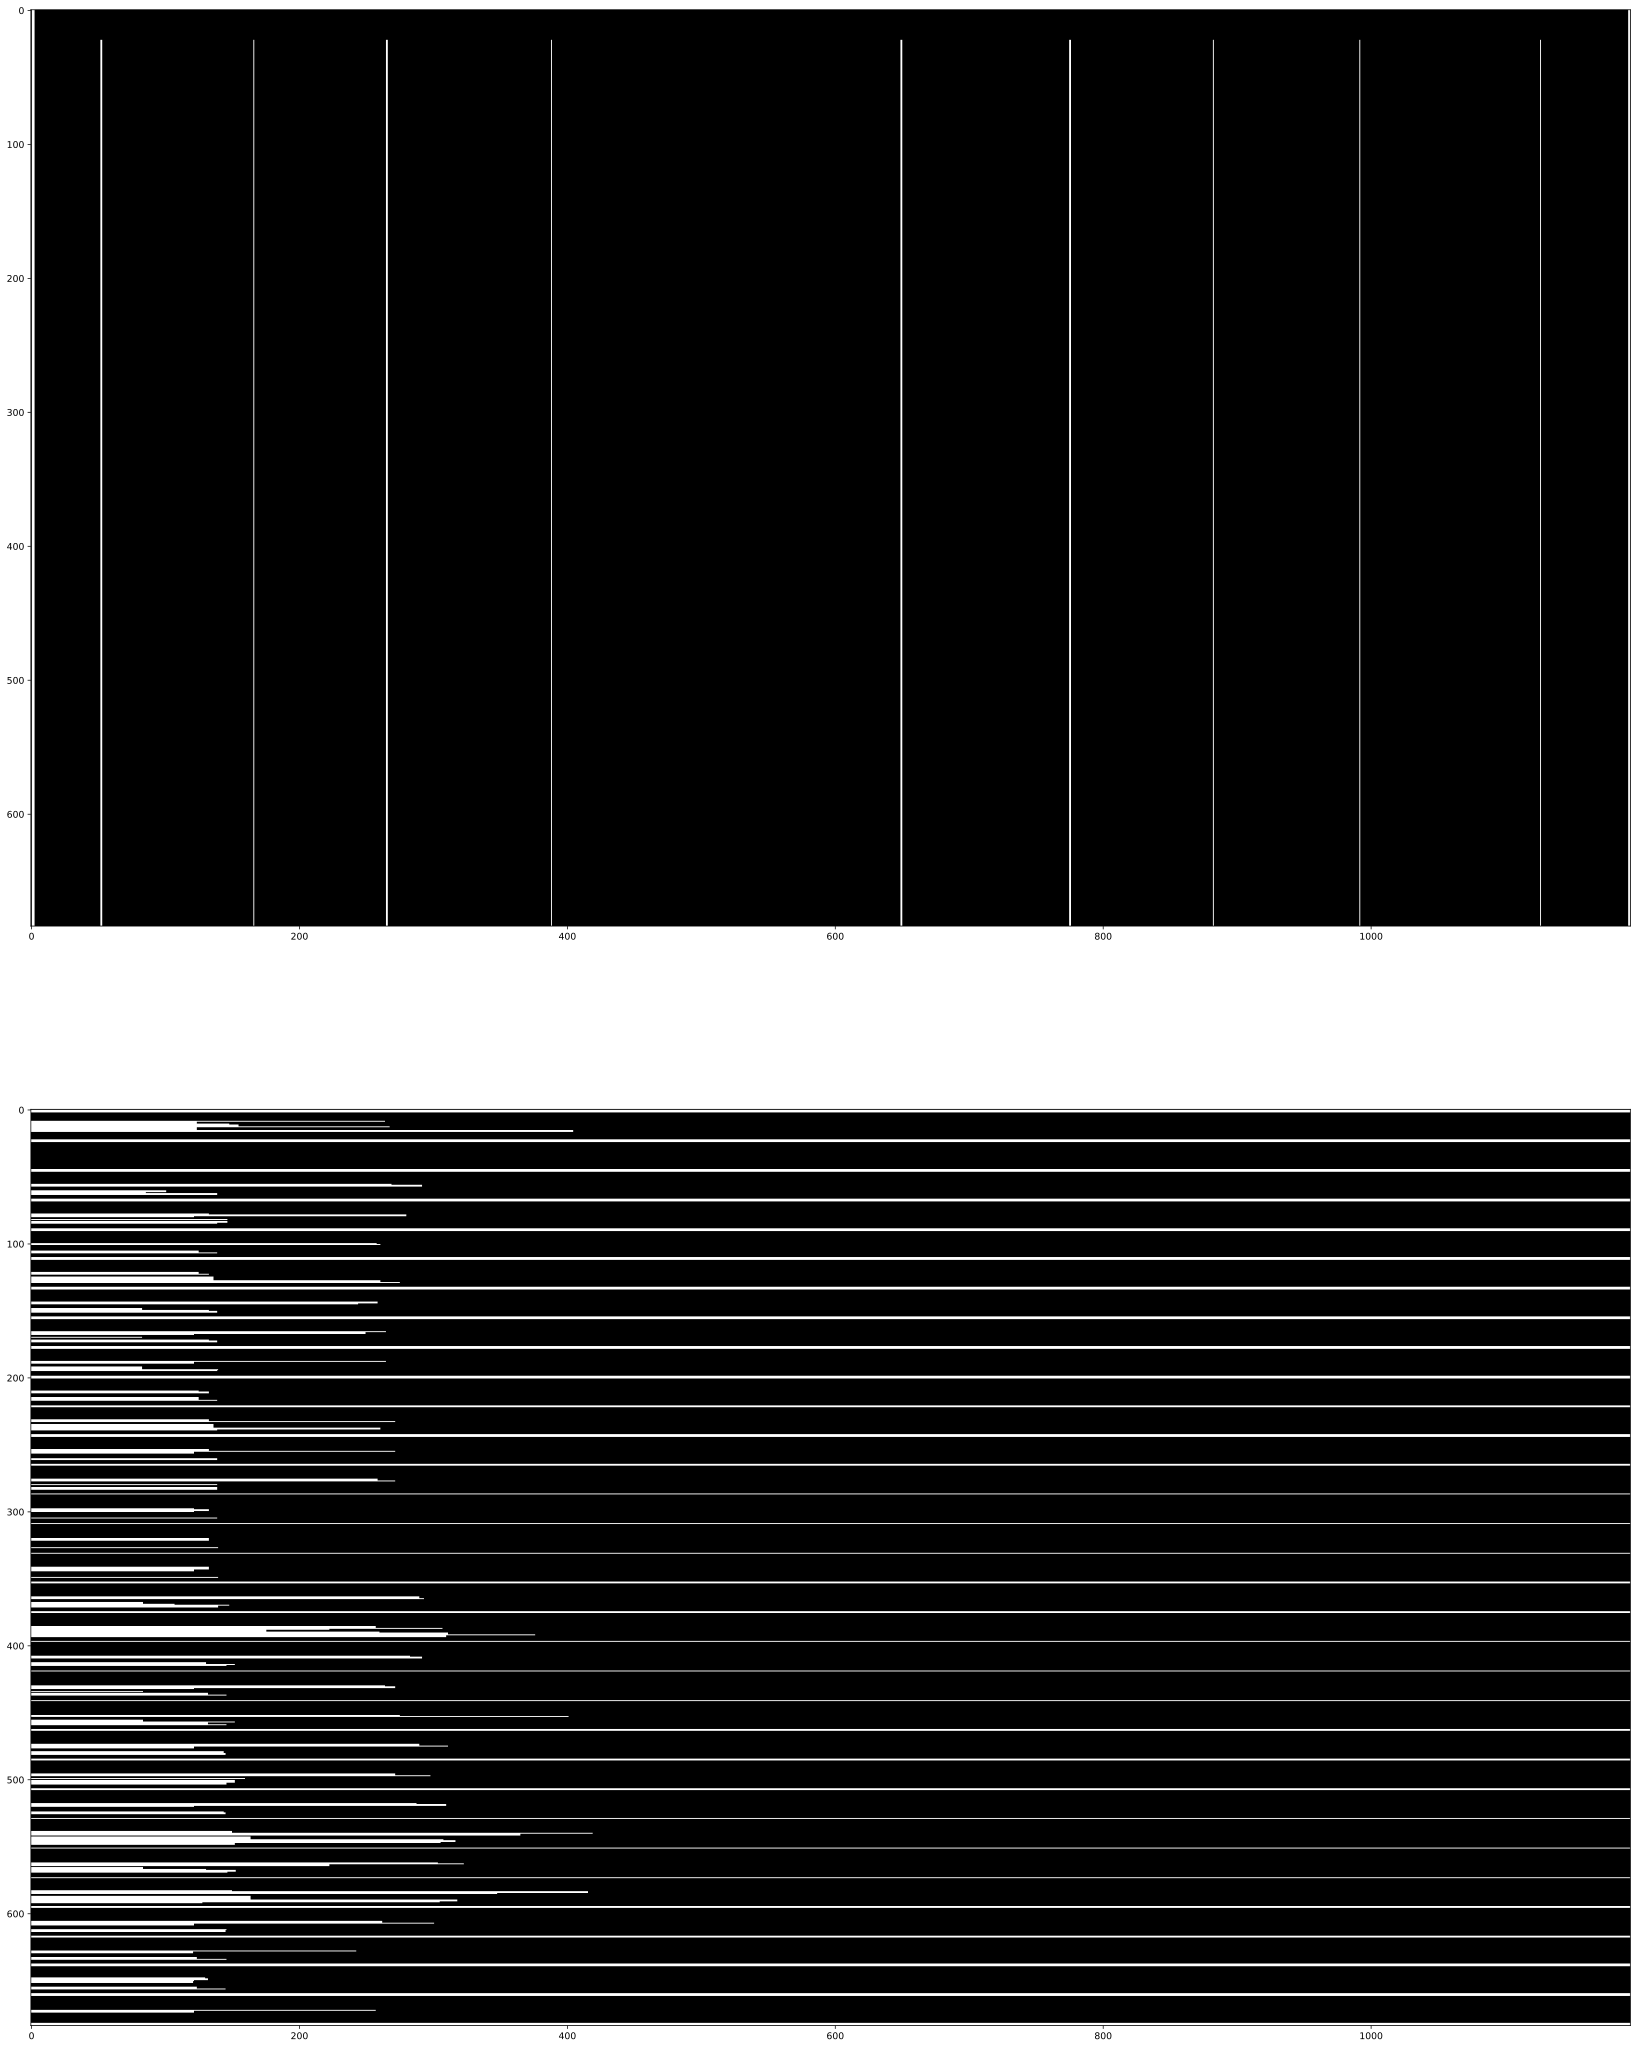

[2, 52, 166, 265, 388, 649, 775, 882, 991, 1126, 1192]
左上角x1=3 y1=3,右下角x2=1191 y2=672
行参考[2, 13, 24, 46, 57, 63, 68, 80, 82, 85, 90, 101, 107, 112, 123, 127, 134, 145, 151, 156, 168, 173, 178, 189, 195, 200, 211, 217, 222, 233, 237, 244, 256, 261, 265, 277, 280, 283, 287, 300, 305, 309, 321, 327, 331, 344, 349, 353, 365, 371, 375, 390, 397, 409, 415, 419, 432, 437, 441, 453, 459, 463, 476, 481, 485, 497, 499, 503, 507, 520, 525, 529, 541, 546, 551, 564, 569, 573, 585, 590, 595, 608, 613, 617, 629, 634, 639, 650, 656, 661, 673]列参考[2, 52, 166, 265, 388, 649, 775, 882, 991, 1126, 1192]
[[1, 3], [52, 53], [166, 167], [265, 266], [388, 389], [649, 650], [775, 776], [882, 883], [991, 992], [1126, 1127], [1192, 1193]] [[1, 3], [9, 17], [23, 25], [45, 47], [56, 58], [61, 64], [67, 69], [78, 81], [82, 83], [84, 86], [89, 91], [100, 102], [106, 108], [111, 113], [122, 124], [125, 130], [133, 135], [144, 146], [150, 152], [155, 157], [166, 169], [172, 174], [177, 179], [188, 190], [194, 196], [19

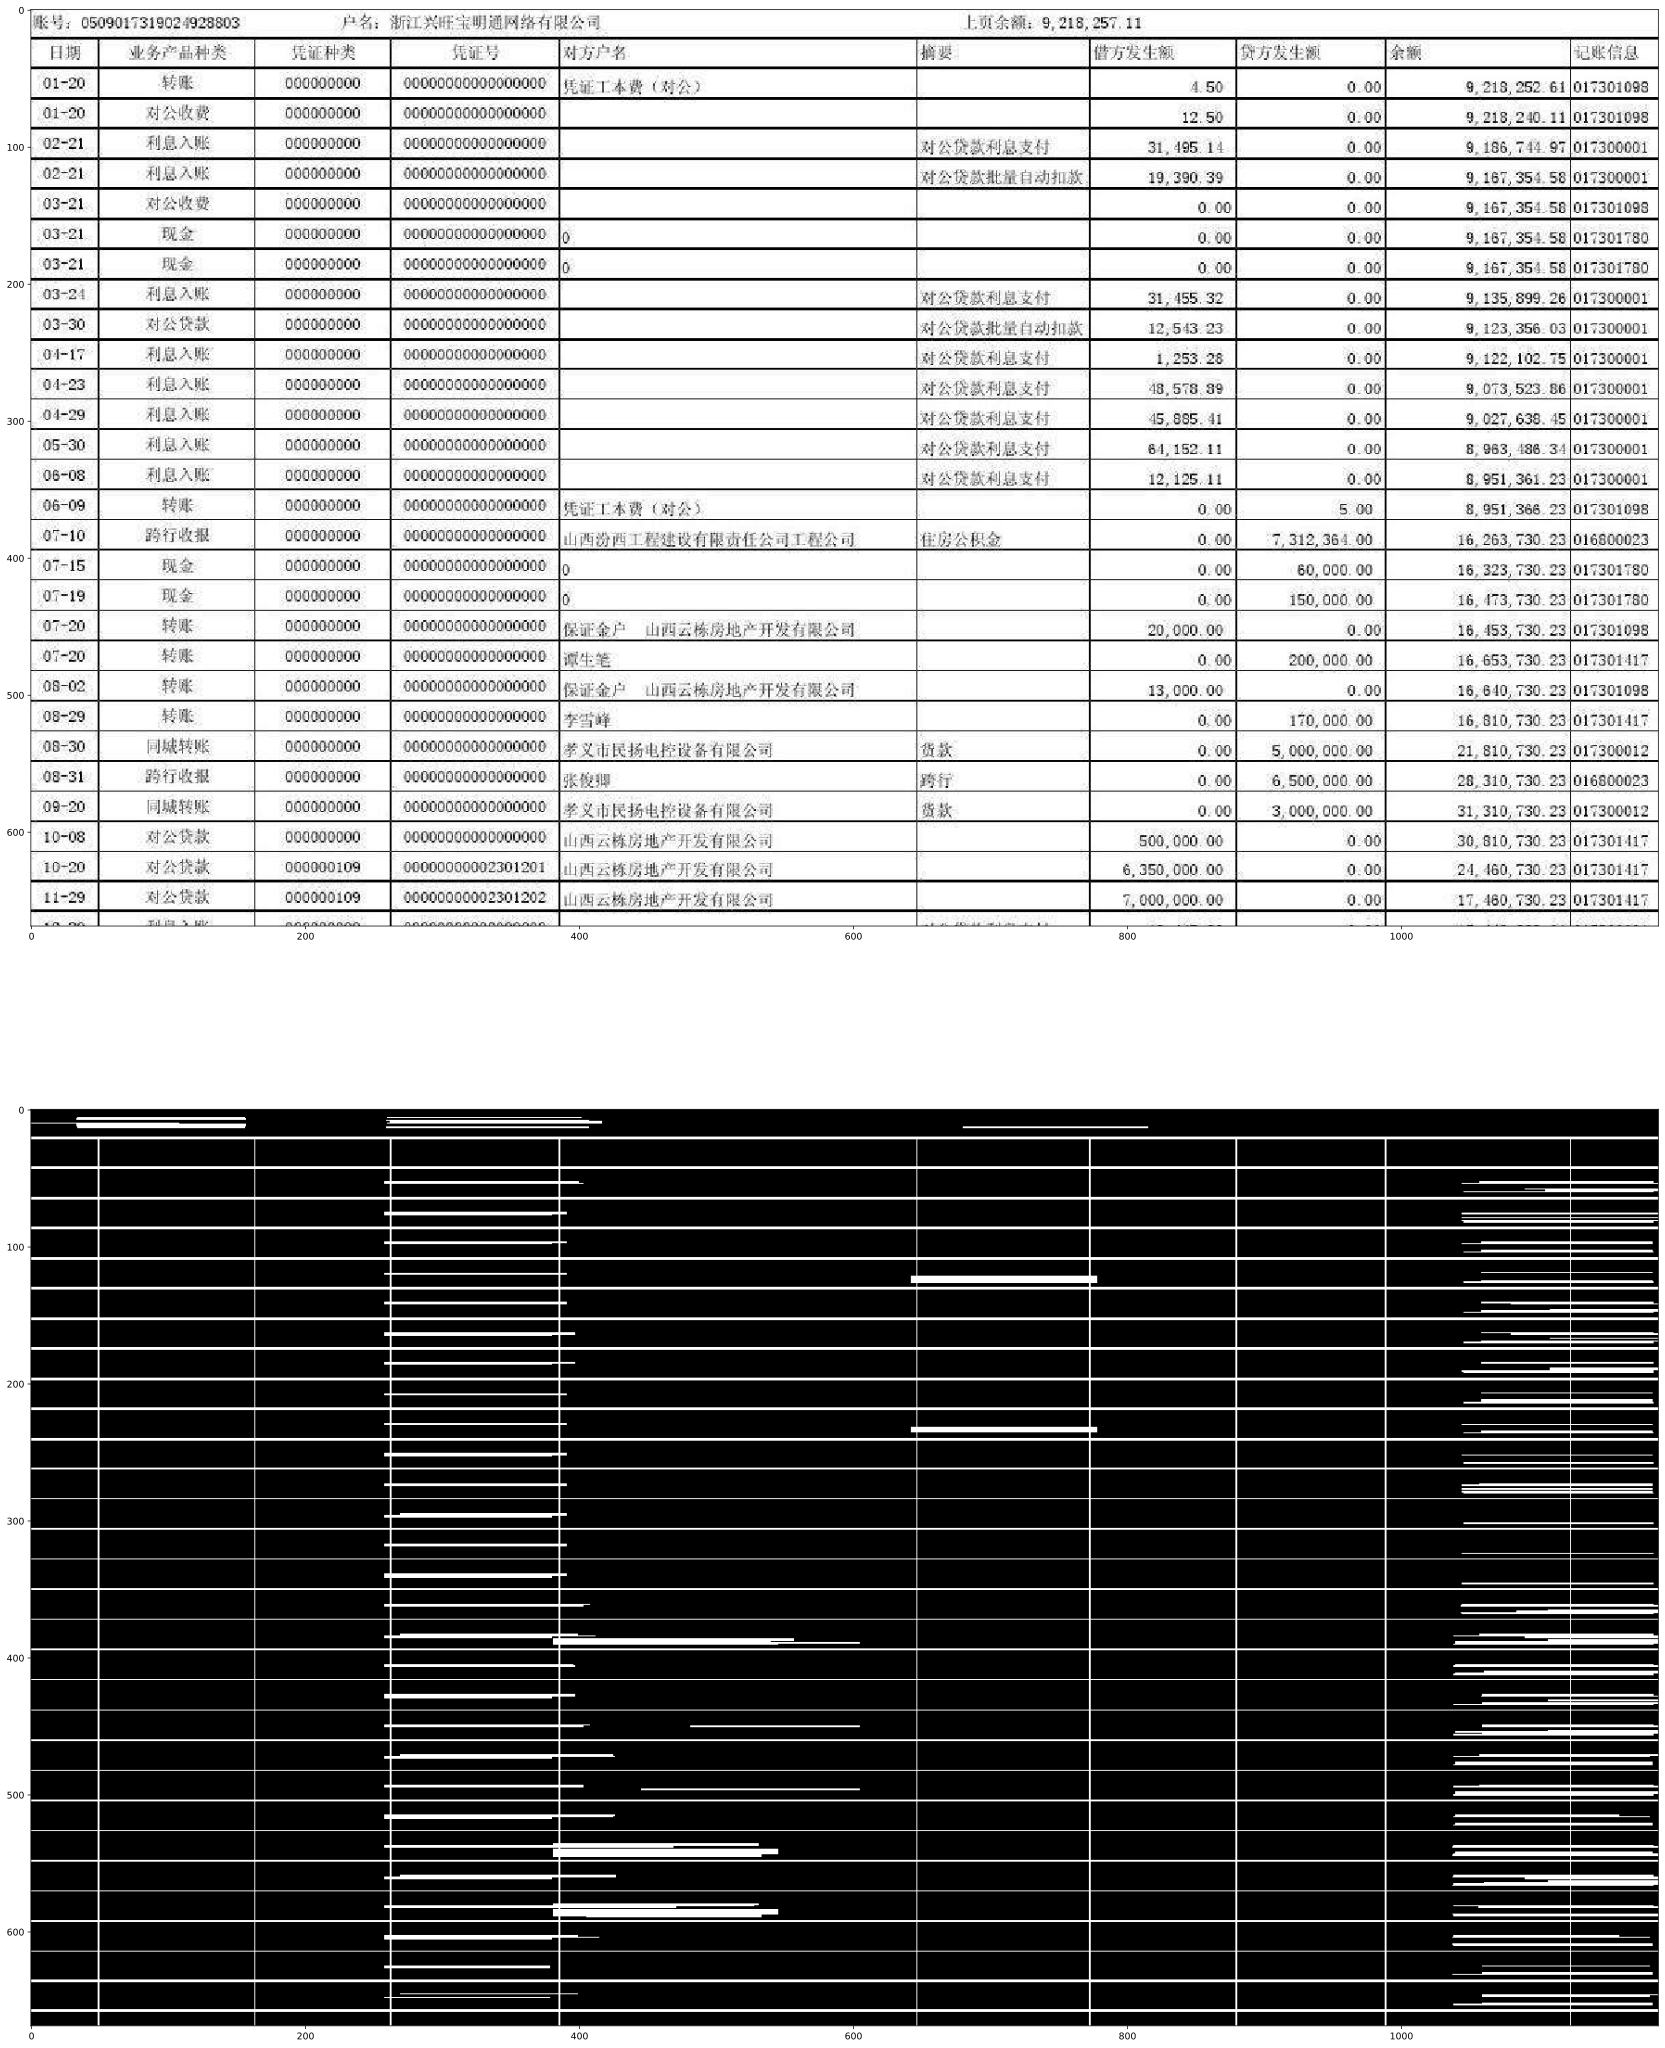

6：分割前预处理
(669, 1188) (669, 1188)


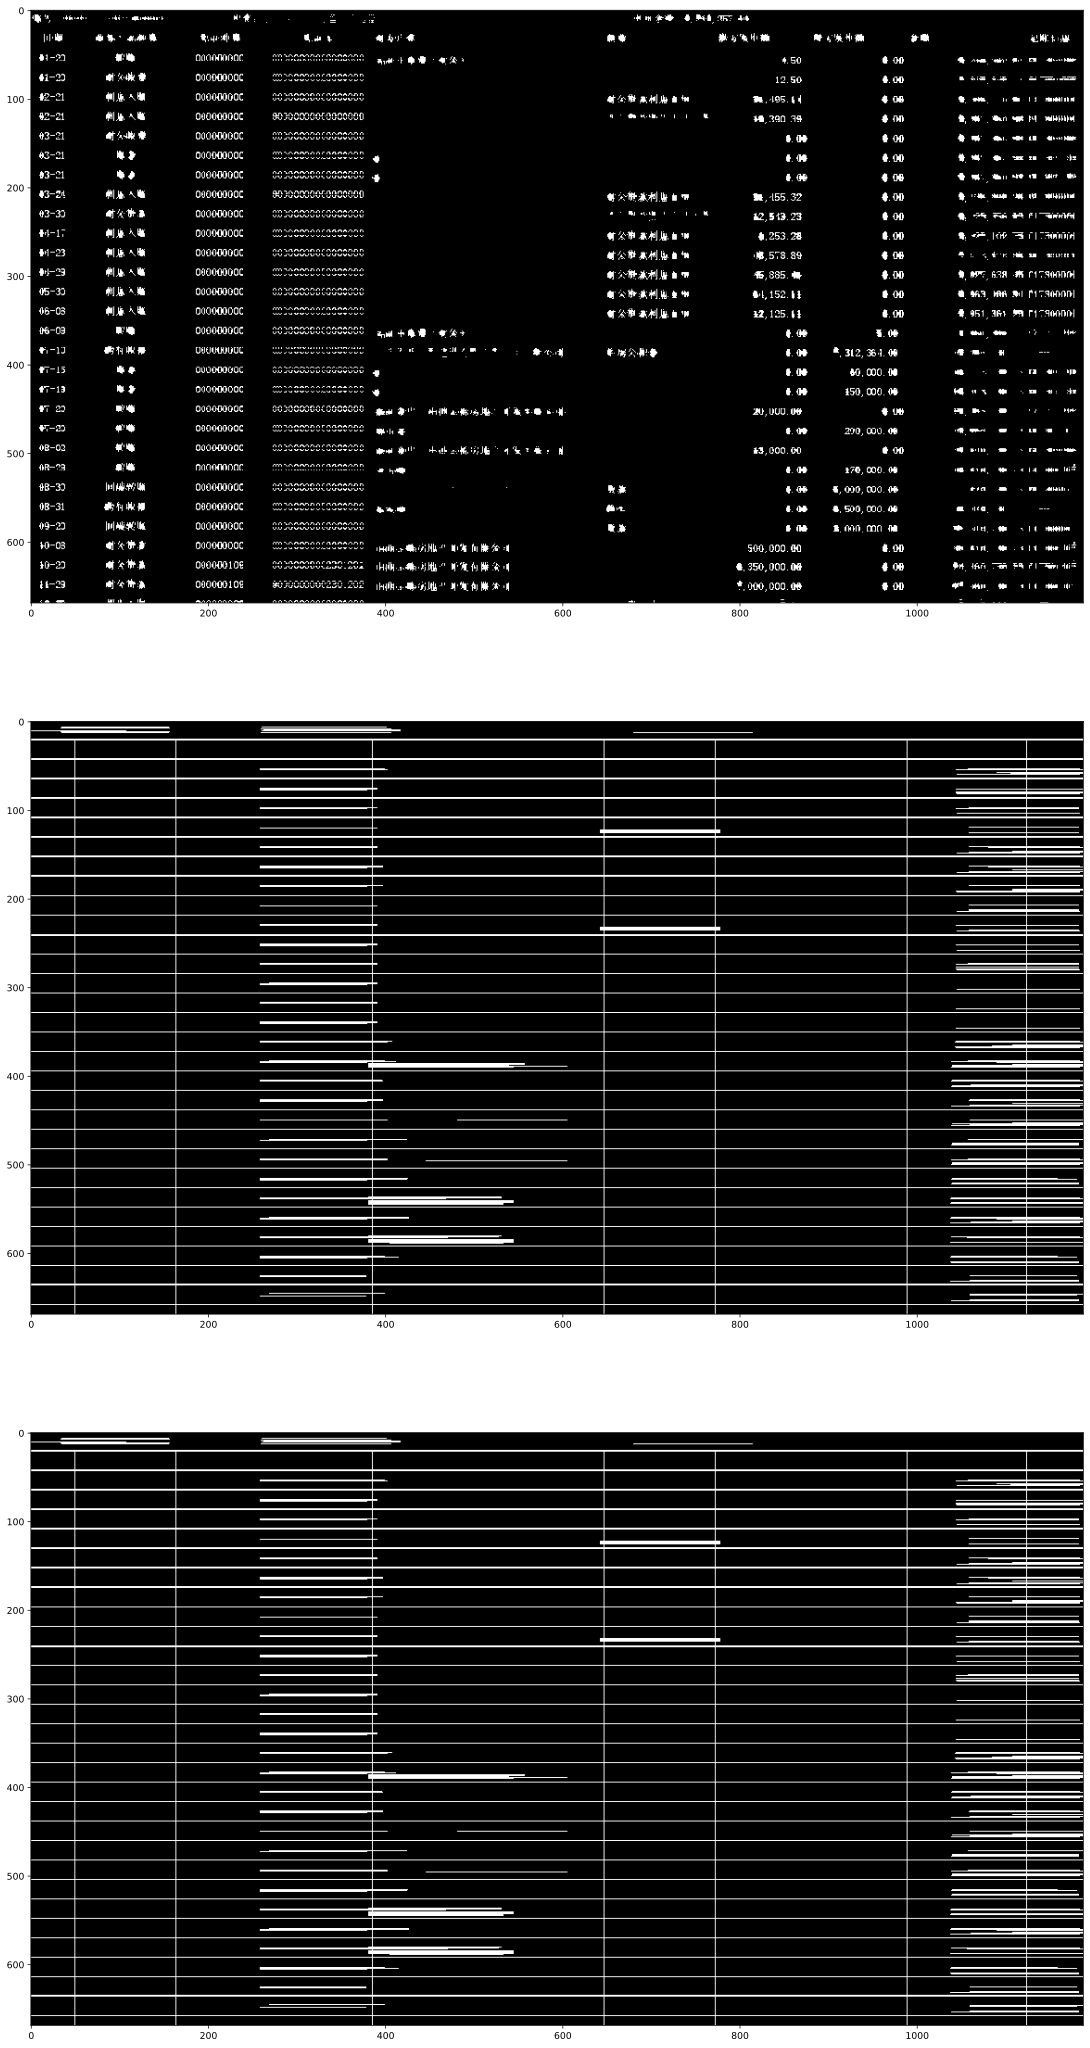

7：计算行和列分割线
60 10
rows= [6, 10, 13, 21, 43, 54, 65, 76, 87, 98, 109, 126, 131, 142, 153, 164, 175, 185, 197, 219, 230, 235, 241, 252, 262, 274, 284, 306, 328, 350, 362, 372, 384, 389, 394, 406, 416, 428, 438, 450, 460, 472, 482, 494, 504, 516, 526, 538, 544, 548, 560, 570, 582, 588, 592, 604, 614, 625, 636, 658]
colums= [49, 163, 262, 385, 646, 772, 879, 988, 1121, 1187]


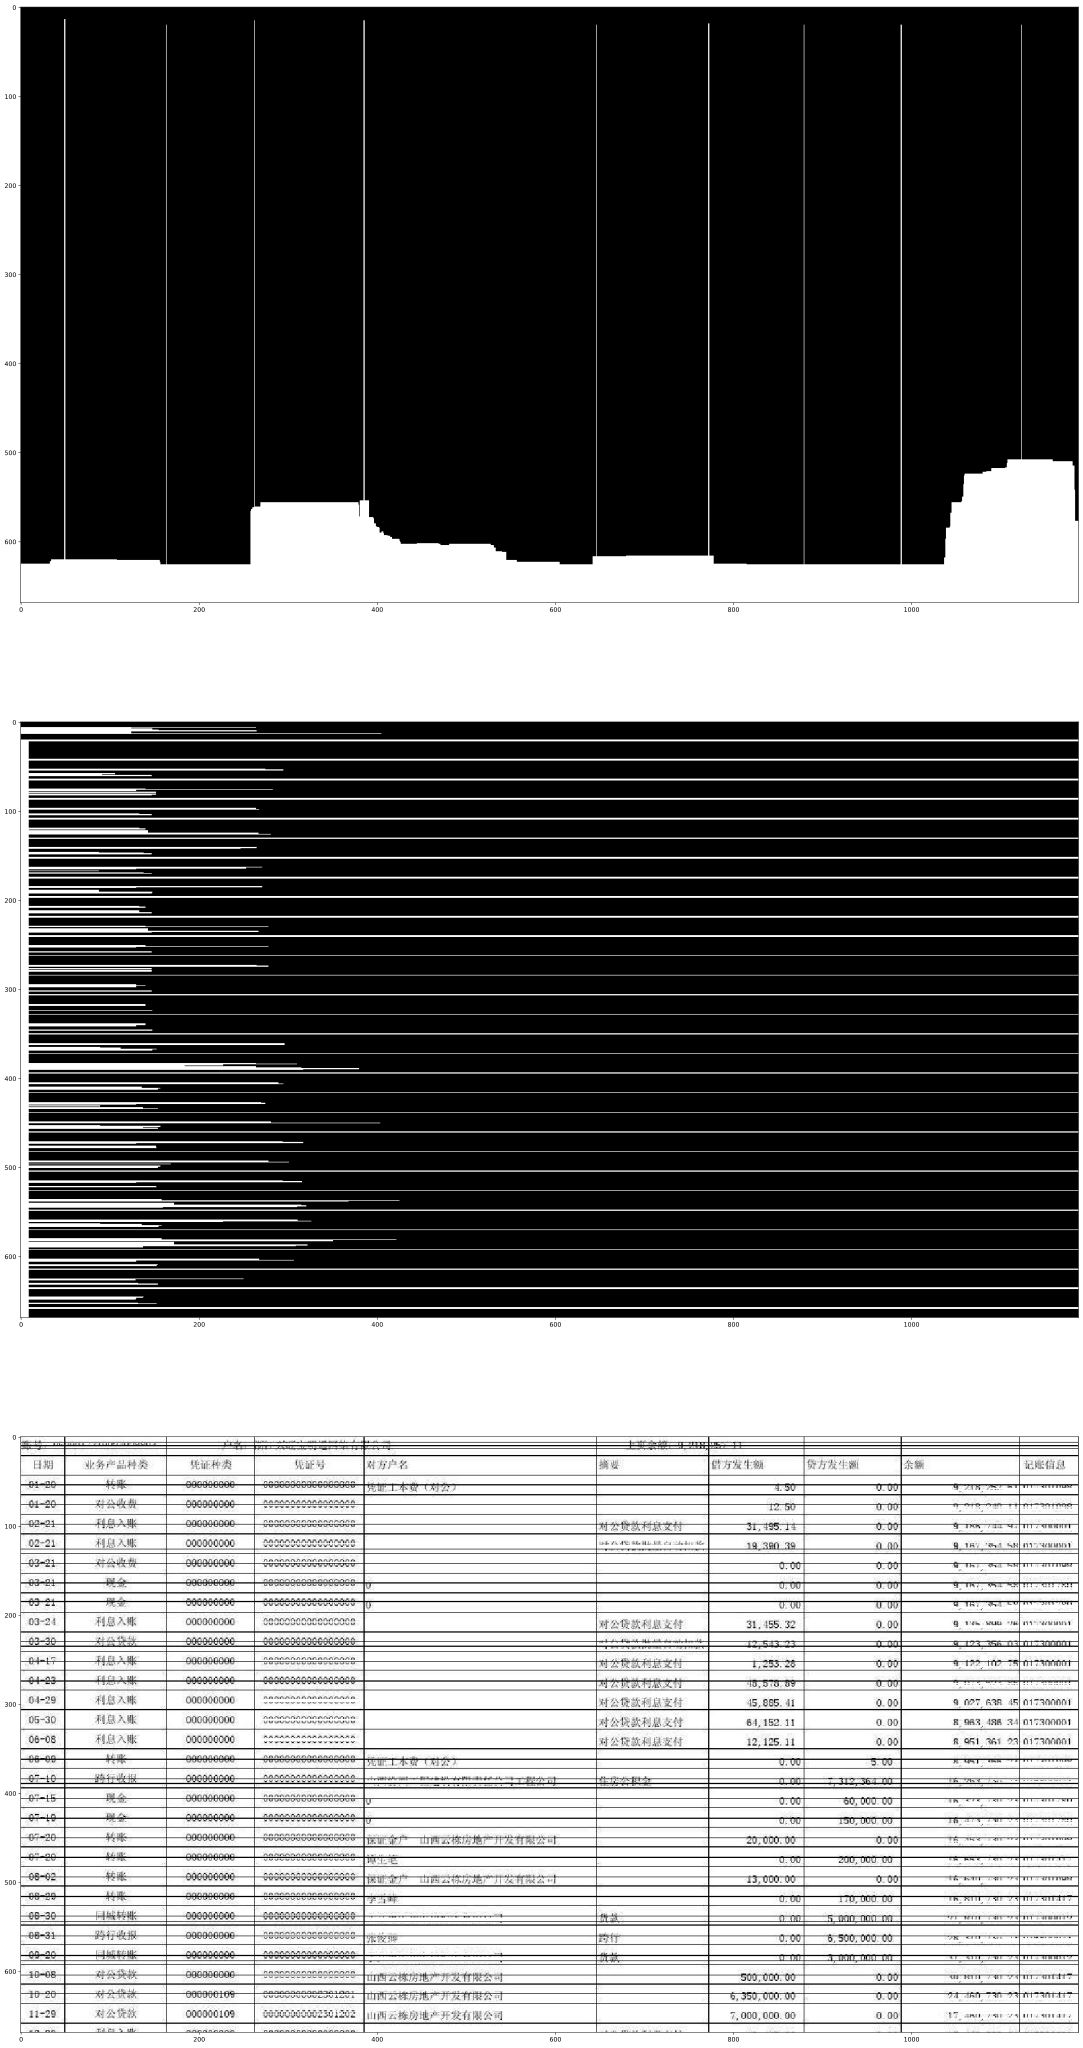

8：每个cell进行识别的tablelist
行0： 列0： 列1： 列2： 列3： 列4： 列5： 列6： 列7： 列8：  
行1： 列0： 列1： 列2： 列3： 列4： 列5： 列6： 列7： 列8：  
行2： 列0： 列1： 列2： 列3： 列4： 列5： 列6： 列7： 列8：  
行3： 列0： 列1： 列2： 列3： 列4： 列5： 列6： 列7： 列8：  
行4： 列0： 列1： 列2： 列3： 列4： 列5： 列6： 列7： 列8：  
行5： 列0： 列1： 列2： 列3： 列4： 列5： 列6： 列7： 列8：  
行6： 列0： 列1： 列2： 列3： 列4： 列5： 列6： 列7： 列8：  
行7： 列0： 列1： 列2： 列3： 列4： 列5： 列6： 列7： 列8：  
行8： 列0： 列1： 列2： 列3： 列4： 列5： 列6： 列7： 列8：  
行9： 列0： 列1： 列2： 列3： 列4： 列5： 列6： 列7： 列8：  
行10： 列0： 列1： 列2： 列3： 列4： 列5： 列6： 列7： 列8：  
行11： 列0： 列1： 列2： 列3： 列4： 列5： 列6： 列7： 列8：  
行12： 列0： 列1： 列2： 列3： 列4： 列5： 列6： 列7： 列8：  
行13： 列0： 列1： 列2： 列3： 列4： 列5： 列6： 列7： 列8：  
行14： 列0： 列1： 列2： 列3： 列4： 列5： 列6： 列7： 列8：  
行15： 列0： 列1： 列2： 列3： 列4： 列5： 列6： 列7： 列8：  
行16： 列0： 列1： 列2： 列3： 列4： 列5： 列6： 列7： 列8：  
行17： 列0： 列1： 列2： 列3： 列4： 列5： 列6： 列7： 列8：  
行18： 列0： 列1： 列2： 列3： 列4： 列5： 列6： 列7： 列8：  
行19： 列0： 列1： 列2： 列3： 列4： 列5： 列6： 列7： 列8：  
行20： 列0： 列1： 列2： 列3： 列4： 列5： 列6： 列7： 列8：  
行21： 列0： 列1： 列2： 列3： 列4： 列5： 列6： 列7： 列8：  
行22： 列0： 列1： 列2： 列3： 列4： 列5： 列6： 列7： 列8： 

In [42]:
# 测试单个image
path = './'
filename="test.jpeg"
ocrimgtoexcel(filename,path,debug=True)
print('ok')

In [ ]:
# this can deal a lot of images in direct.
import os
fpathe = './'
print("处理 {} 目录下图片".format(fpathe))
writer = pd.ExcelWriter(os.path.join(fpathe,'allpages.xlsx'))
all_tablelist = []
for fpath,dirs,fs in os.walk(fpathe):
    
    for file in fs:
        fname,extension = os.path.splitext(file)
        
        if extension != '.jpg':
            continue
        print("---- {} is start---".format(file))
        tablelist = ocrimgtoexcel(file,fpath,debug=False)
        all_tablelist.append(['No {} page'.format(fname)])
        all_tablelist.extend(tablelist)
        
        print("----{} is complete--- ".format(file))
sheet_data=pd.DataFrame(all_tablelist)
sheet_data.to_excel(writer, sheet_name=fname)
writer.save()
writer.close()  

In [ ]:
import os
debug = True
path = 'j:/2/'
filename="2.jpg"

print('1：读取文件')
filepath=os.path.join(path,filename)
img = cv2.imread(filepath,0)
# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)
sigma = 1; threshold = 3; amount = 1
blurred=cv2.GaussianBlur(cl1,(0,0),1,None,1)
#blurred1 = cv2.adaptiveThreshold(
#    blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, -2)
lowContrastMask = abs(cl1 - blurred) < threshold
sharpened = blurred*(1+amount) + blurred*(-amount)
image=cv2.bitwise_or(sharpened.astype(np.uint8),lowContrastMask.astype(np.uint8))
plt.gcf().set_size_inches(50.0,60.0)
plt.subplot(2,1,1),plt.imshow(blurred,'gray')
plt.subplot(2,1,2),plt.imshow(image,'gray')
plt.show()

In [ ]:

hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

In [ ]:
import os
debug = True

path = 'I:/2'
filename="2_页面_01.jpg"

print('1：读取文件')
filepath=os.path.join(path,filename)
iproc_obj = imgproc.ImageProc(filepath)
thresh_img = cv2.adaptiveThreshold(
    iproc_obj.gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 25, 11) #二值化,通过阈值删除噪音
hscale = 10

h_img = thresh_img.copy()
h_size = int(h_img.shape[1]/hscale)
x_structure = cv2.getStructuringElement(
    cv2.MORPH_RECT, (3, 3))



h_structure = cv2.getStructuringElement(
    cv2.MORPH_RECT, (h_size, 1))  # 形态学因子

h_erode_structure = cv2.getStructuringElement(
    cv2.MORPH_RECT, (1, 5))  # 形态学因子
#h_dilate_imgT = cv2.dilate(h_img, h_structure, 1) # 横向膨胀
#h_erode_img = cv2.erode(h_dilate_imgT, h_structure, 1) #腐蚀掉非水平的对象
h_MORPH_CLOSE_img=    cv2.morphologyEx(h_img,cv2.MORPH_CLOSE,h_structure)
h_erode_img = cv2.erode(h_MORPH_CLOSE_img, h_erode_structure, 1) 


v_img = thresh_img.copy()
vscale = 10
v_size = int(v_img.shape[0]/vscale)

v_structure = cv2.getStructuringElement(
    cv2.MORPH_RECT, (1, v_size))  # 形态学因子
v_erode_structure = cv2.getStructuringElement(    imgThresh = cv2.fastNlMeansDenoising(rotate_image, None, 21, 11, 21)
    #imgThresh = cv2.fastNlMeansDenoisingColored(rotate_image, None, 10, 10, 7, 21)
 # 形态学因子
#v_dilate_imgT = cv2.dilate(v_img, v_dashed_structure, 1) # 虚线转为实线
#v_erode_img = cv2.erode(v_dilate_imgT, v_structure, 1) #腐蚀掉非水平的对象
v_MORPH_CLOSE_img=    cv2.morphologyEx(v_img,cv2.MORPH_CLOSE,v_structure)
#v_erode_img = cv2.erode(v_MORPH_CLOSE_img, v_erode_structure, 1)
v_erode_img=    cv2.morphologyEx(v_MORPH_CLOSE_img,cv2.MORPH_CLOSE,v_erode_structure)
if debug:
    plt.gcf().set_size_inches(40.0,50.0)
    plt.subplot(3,1,1),plt.imshow(thresh_img,'gray')
    plt.subplot(3,1,2),plt.imshow(h_erode_img,'gray')
    plt.subplot(3,1,3),plt.imshow(v_erode_img,'gray')
    plt.show()

In [ ]:
import os
debug = True

path = '.2'
filename="2_页面_01.jpg"

print('1：读取文件')
filepath=os.path.join(path,filename)
iproc_obj = imgproc.ImageProc(filepath)
thresh_img = cv2.adaptiveThreshold(
    iproc_obj.gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 45, 9)
h_img = thresh_img.copy()
hscale = hscale
h_size = int(h_img.shape[1]/hscale)

h_structure = cv2.getStructuringElement(
    cv2.MORPH_RECT, (h_size, 1))  # 形态学因子
h_dashed_structure = cv2.getStructuringElement(
    cv2.MORPH_RECT, (5, 1))  # 形态学因子
h_dilate_imgT = cv2.dilate(h_img, h_dashed_structure, 1) # 虚线转为实线
h_erode_img = cv2.erode(h_dilate_imgT, h_structure, 1) #腐蚀掉非水平的对象
h_dilate_img = cv2.dilate(h_erode_img, h_structure, 1)


v_img = thresh_img.copy()
vscale = vscale
v_size = int(v_img.shape[0]/vscale)

v_structure = cv2.getStructuringElement(
    cv2.MORPH_RECT, (1, v_size))  # 形态学因子
v_dashed_structure = cv2.getStructuringElement(
    cv2.MORPH_RECT, (1, 1))  # 形态学因子
v_dilate_imgT = cv2.dilate(v_img, v_dashed_structure, 1) # 虚线转为实线
v_erode_img = cv2.erode(v_dilate_imgT, v_structure, 1) #腐蚀掉非水平的对象
v_dilate_img = cv2.dilate(v_erode_img, v_structure, 1)

if debug:
    plt.gcf().set_size_inches(40.0,50.0)
    plt.subplot(3,1,1),plt.imshow(thresh_img,'gray')
    plt.subplot(3,1,2),plt.imshow(h_dilate_img,'gray')
    plt.subplot(3,1,3),plt.imshow(v_dilate_img,'gray')
    plt.show()

In [ ]:
img = cv2.imread(filepath,0)
equ = cv2.equalizeHist(img)
res = np.hstack((img,equ)) #stacking images side-by-side
plt.gcf().set_size_inches(60.0,40.0)
plt.subplot(2,1,1),plt.imshow(img,'gray')
plt.subplot(2,1,2),plt.imshow(equ,'gray')
plt.show()